#Spark setup

In [ ]:
 # Install Spark 3.0.1
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar xf spark-3.0.1-bin-hadoop2.7.tgz

In [ ]:
# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

In [ ]:
# Install findspark
!python -m pip install -q findspark

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession

In [ ]:
APP_NAME = "Capstone"
SPARK_URL = "local[*]"

In [ ]:
spark = SparkSession.builder.appName(APP_NAME).getOrCreate()

In [ ]:
spark

#Kaggle API

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


#Loading Kaggle data

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
!kaggle datasets download -d asaniczka/tmdb-movies-dataset-2023-930k-movies

Dataset URL: https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies
License(s): ODC Attribution License (ODC-By)
tmdb-movies-dataset-2023-930k-movies.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/tmdb-movies-dataset-2023-930k-movies.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
#put csv into pandas dataframe
location = '/content/TMDB_movie_dataset_v11.csv'
TMDB_movie = pd.read_csv(location)
TMDB_movie.drop(columns=['backdrop_path', 'homepage', 'overview', 'poster_path', 'tagline'], inplace=True)

# Save the updated DataFrame back to the CSV file
TMDB_movie.to_csv(location, index=False)

TMDB_movie.head()

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,budget,imdb_id,original_language,original_title,popularity,genres,production_companies,production_countries,spoken_languages,keywords
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,False,160000000,tt1375666,en,Inception,83.952,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc..."
1,157336,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,False,165000000,tt0816692,en,Interstellar,140.241,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English,"rescue, future, spacecraft, race against time,..."
2,155,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,False,185000000,tt0468569,en,The Dark Knight,130.643,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin","joker, sadism, chaos, secret identity, crime f..."
3,19995,Avatar,7.573,29815,Released,2009-12-15,2923706026,162,False,237000000,tt0499549,en,Avatar,79.932,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish","future, society, culture clash, space travel, ..."
4,24428,The Avengers,7.710,29166,Released,2012-04-25,1518815515,143,False,220000000,tt0848228,en,The Avengers,98.082,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian","new york city, superhero, shield, based on com..."


#Data Preprocessing

In [ ]:
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, StringType, BooleanType

# Load the DataFrame with the explicit schema
spark_df = spark.read.format('csv').option('header', 'true').option('inferSchema', 'true').load(location)
spark_df.show(5)
spark_df.printSchema()

+------+---------------+------------+----------+--------+------------+----------+-------+-----+---------+---------+-----------------+---------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    id|          title|vote_average|vote_count|  status|release_date|   revenue|runtime|adult|   budget|  imdb_id|original_language| original_title|popularity|              genres|production_companies|production_countries|    spoken_languages|            keywords|
+------+---------------+------------+----------+--------+------------+----------+-------+-----+---------+---------+-----------------+---------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
| 27205|      Inception|       8.364|     34495|Released|  2010-07-15| 825532764|    148|False|160000000|tt1375666|               en|      Inception|    83.952|Action, Science F...|Legendary Picture...|

In [ ]:
from pyspark.sql.functions import to_date, col

#clean release date column
spark_df = spark_df.withColumn('Date_Released', to_date(col('release_date'), 'yyyy-MM-dd'))
spark_sorted = spark_df.sort(spark_df['Date_Released'].desc())
spark_dropped = spark_sorted.drop('release_date')
spark_dropped = spark_dropped.dropna(subset=['Date_Released'])
spark_dropped.show(5)

+-------+--------------------+------------+----------+---------------+-------+-------+-----+------+---------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+----------------+--------------------+-------------+
|     id|               title|vote_average|vote_count|         status|revenue|runtime|adult|budget|  imdb_id|original_language|      original_title|popularity|              genres|production_companies|production_countries|spoken_languages|            keywords|Date_Released|
+-------+--------------------+------------+----------+---------------+-------+-------+-----+------+---------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+----------------+--------------------+-------------+
| 401563|           100 Years|         0.0|         0|Post Production|      0|      0|False|     0|tt5174640|               en|           100 Years|     2.238|Drama, Science F

In [ ]:
# Filter rows where vote_count is 0 and count them
zero_vote_count = spark_dropped.filter(col('vote_count') == 0).count()
print(f"Number of rows where vote_count is 0: {zero_vote_count}")

Number of rows where vote_count is 0: 579990


In [ ]:
# Drop rows where vote_count is 0
#spark_dropped = spark_dropped.filter(col('vote_count') != 0)

# A true "movie" must be at least 75 minutes long?
#spark_dropped = spark_dropped.filter(col('runtime') >= 75)

spark_dropped = spark_dropped.dropna(subset=['Date_Released', 'imdb_id'])

spark_dropped.show(5)

from pyspark.sql.functions import count, when, min, max

# Print the number of rows
num_rows = spark_dropped.count()
print(f"Number of rows: {num_rows}")

# Print the number of columns
num_cols = len(spark_dropped.columns)
print(f"Number of columns: {num_cols}")

# Count Nulls in Each Column
null_counts = spark_dropped.select([count(when(col(c).isNull(), c)).alias(c) for c in spark_dropped.columns])

# Identify Numerical and Categorical Columns
numerical_cols = [c[0] for c in spark_dropped.dtypes if c[1] in ['int', 'double']]
categorical_cols = [c[0] for c in spark_dropped.dtypes if c[1] == 'string']

# Print Overview
print("Null Counts in Each Column:")
null_counts.show()

+-------+--------------------+------------+----------+---------------+-------+-------+-----+---------+----------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+----------------+--------+-------------+
|     id|               title|vote_average|vote_count|         status|revenue|runtime|adult|   budget|   imdb_id|original_language|      original_title|popularity|              genres|production_companies|production_countries|spoken_languages|keywords|Date_Released|
+-------+--------------------+------------+----------+---------------+-------+-------+-----+---------+----------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+----------------+--------+-------------+
| 401563|           100 Years|         0.0|         0|Post Production|      0|      0|False|        0| tt5174640|               en|           100 Years|     2.238|Drama, Science Fi...|Troublemaker St

In [ ]:
import pyspark.sql.functions as F

In [ ]:
# Filter rows where vote_count is 0 and count them
zero_rev_count = spark_dropped.filter(col('revenue') == 0).count()
print(f"Number of rows where revenue_count is 0: {zero_rev_count}")

Number of rows where revenue_count is 0: 531591


In [ ]:
# Filter rows where vote_count is 0 and count them
zero_budg_count = spark_dropped.filter(col('budget') == 0).count()
print(f"Number of rows where budget_count is 0: {zero_budg_count}")

Number of rows where budget_count is 0: 513909


In [ ]:
#drop rows with revenue <= 1,000 & budge = 0
spark_rev = spark_dropped.filter((F.col('revenue').isNotNull()) & (F.col('revenue') > 0))
spark_budg = spark_rev.filter((F.col('budget').isNotNull()) & (F.col('budget') > 0))
spark_budg.show(5)

+-------+--------------------+------------+----------+-------------+-------+-------+-----+------+----------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+----------------+--------------------+-------------+
|     id|               title|vote_average|vote_count|       status|revenue|runtime|adult|budget|   imdb_id|original_language|      original_title|popularity|              genres|production_companies|production_countries|spoken_languages|            keywords|Date_Released|
+-------+--------------------+------------+----------+-------------+-------+-------+-----+------+----------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+----------------+--------------------+-------------+
|1324984|   Finding Her Voice|         0.0|         0|     Released|    100|      8|False|    10|tt33059737|               en|   Finding Her Voice|       1.4|        Drama, Music

In [ ]:
spark_budg.count()

10601

In [ ]:
from pyspark.sql.types import IntegerType, FloatType

#changing type to Integer
data_nums = spark_budg.withColumn("budget", F.col("budget").cast(IntegerType())) \
                .withColumn("revenue", F.col("revenue").cast(IntegerType())) \
                .withColumn("vote_average", F.col("vote_average").cast(FloatType())) \
                .withColumn("vote_count", F.col("vote_count").cast(IntegerType())) \
                .withColumn("runtime", F.col("runtime").cast(IntegerType())) \
                .withColumn("popularity", F.col("popularity").cast(FloatType()))
#varifying it worked
data_nums.printSchema()

root
 |-- id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: float (nullable = true)
 |-- vote_count: integer (nullable = true)
 |-- status: string (nullable = true)
 |-- revenue: integer (nullable = true)
 |-- runtime: integer (nullable = true)
 |-- adult: string (nullable = true)
 |-- budget: integer (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- popularity: float (nullable = true)
 |-- genres: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- keywords: string (nullable = true)
 |-- Date_Released: date (nullable = true)



In [ ]:
#calculating profit with revenue and budget
profit = data_nums.withColumn('ProfitValue', data_nums.revenue - data_nums.budget)
profit.show(10)

+-------+--------------------+------------+----------+-------------+-------+-------+-----+------+----------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+----------------+--------------------+-------------+-----------+
|     id|               title|vote_average|vote_count|       status|revenue|runtime|adult|budget|   imdb_id|original_language|      original_title|popularity|              genres|production_companies|production_countries|spoken_languages|            keywords|Date_Released|ProfitValue|
+-------+--------------------+------------+----------+-------------+-------+-------+-----+------+----------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+----------------+--------------------+-------------+-----------+
|1324984|   Finding Her Voice|         0.0|         0|     Released|    100|      8|False|    10|tt33059737|               en|   Finding Her V

In [ ]:
#registering the table to SQL
profit.createOrReplaceTempView("profit")

#showing profit count of negative profits
spark.sql("SELECT count(ProfitValue) FROM profit where ProfitValue < 0" ).show()

+------------------+
|count(ProfitValue)|
+------------------+
|              3421|
+------------------+



In [ ]:
from pyspark.sql.functions import when

#create a classification column for Profit True or False
profit_class = profit.withColumn("Profit_TorF",when(profit.ProfitValue > 0, 1).when(profit.ProfitValue <= 0, 0).otherwise(2))
profit_class.show(5)

+-------+--------------------+------------+----------+-------------+-------+-------+-----+------+----------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+----------------+--------------------+-------------+-----------+-----------+
|     id|               title|vote_average|vote_count|       status|revenue|runtime|adult|budget|   imdb_id|original_language|      original_title|popularity|              genres|production_companies|production_countries|spoken_languages|            keywords|Date_Released|ProfitValue|Profit_TorF|
+-------+--------------------+------------+----------+-------------+-------+-------+-----+------+----------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+----------------+--------------------+-------------+-----------+-----------+
|1324984|   Finding Her Voice|         0.0|         0|     Released|    100|      8|False|    10|tt3305973

In [ ]:
from pyspark.sql.functions import split

#Parse out year of release date
parsed_date = profit_class.withColumn('Year_Released', split(profit_class['Date_Released'], '-').getItem(0))
parsed_date.show(10)

+-------+--------------------+------------+----------+-------------+-------+-------+-----+------+----------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+----------------+--------------------+-------------+-----------+-----------+-------------+
|     id|               title|vote_average|vote_count|       status|revenue|runtime|adult|budget|   imdb_id|original_language|      original_title|popularity|              genres|production_companies|production_countries|spoken_languages|            keywords|Date_Released|ProfitValue|Profit_TorF|Year_Released|
+-------+--------------------+------------+----------+-------------+-------+-------+-----+------+----------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+----------------+--------------------+-------------+-----------+-----------+-------------+
|1324984|   Finding Her Voice|         0.0|         0|     Relea

In [ ]:
from pyspark.sql.types import IntegerType, FloatType

#changing year type to Integer
parsed_date = parsed_date.withColumn("Year_Released", F.col("Year_Released").cast(IntegerType()))

#varifying it worked
parsed_date.printSchema()

root
 |-- id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: float (nullable = true)
 |-- vote_count: integer (nullable = true)
 |-- status: string (nullable = true)
 |-- revenue: integer (nullable = true)
 |-- runtime: integer (nullable = true)
 |-- adult: string (nullable = true)
 |-- budget: integer (nullable = true)
 |-- imdb_id: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- popularity: float (nullable = true)
 |-- genres: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- keywords: string (nullable = true)
 |-- Date_Released: date (nullable = true)
 |-- ProfitValue: integer (nullable = true)
 |-- Profit_TorF: integer (nullable = false)
 |-- Year_Released: integer (nullable = true)



In [ ]:
parsed_date.count()

10601

In [ ]:
from pyspark.sql.functions import when

#Creating a covid classification column pre and post covid
movie_classified = parsed_date.withColumn("Covid",when(parsed_date.Year_Released > 2019, 'Post').when(parsed_date.Year_Released <= 2019, 'Pre').otherwise('covid unknown'))
movie_classified.show(10)

+-------+--------------------+------------+----------+-------------+-------+-------+-----+------+----------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+----------------+--------------------+-------------+-----------+-----------+-------------+-----+
|     id|               title|vote_average|vote_count|       status|revenue|runtime|adult|budget|   imdb_id|original_language|      original_title|popularity|              genres|production_companies|production_countries|spoken_languages|            keywords|Date_Released|ProfitValue|Profit_TorF|Year_Released|Covid|
+-------+--------------------+------------+----------+-------------+-------+-------+-----+------+----------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+----------------+--------------------+-------------+-----------+-----------+-------------+-----+
|1324984|   Finding Her Voice|         0.0|   

In [ ]:
import requests
import gzip
import shutil
import pandas as pd
import numpy as np

# URL for the IMDB Non-Commercial Crew Members Dataset
url = 'https://datasets.imdbws.com/title.crew.tsv.gz'

# Download the dataset
response = requests.get(url, stream=True)
filename = 'title.crew.tsv.gz'

# Save the file
with open(filename, 'wb') as file:
    file.write(response.content)

# Extract the file
with gzip.open(filename, 'rb') as f_in:
    with open('title.crew.tsv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

# Read the TSV file into a Pandas DataFrame
title_crew = pd.read_csv('title.crew.tsv', delimiter='\t', low_memory=False)

# Display the DataFrame
title_crew.dtypes
title_crew['directors'] = title_crew['directors'].astype(str)
title_crew['first_director'] = title_crew['directors'].apply(lambda x: x.split(',')[0])
title_crew.drop(columns=['directors', 'writers'],axis=1, inplace=True)
title_crew.head()

,tconst,first_director
0,tt0000001,nm0005690
1,tt0000002,nm0721526
2,tt0000003,nm0721526
3,tt0000004,nm0721526
4,tt0000005,nm0005690


In [ ]:
import requests
import gzip
import shutil
import pandas as pd

# URL for the IMDB Non-Commercial Person Dataset
url = 'https://datasets.imdbws.com/name.basics.tsv.gz'

# Download the dataset
response = requests.get(url, stream=True)
filename = 'name.basics.tsv.gz'

# Save the file
with open(filename, 'wb') as file:
    file.write(response.content)

# Extract the file
with gzip.open(filename, 'rb') as f_in:
    with open('name.basics.tsv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

# Read the TSV file into a Pandas DataFrame
name_basics = pd.read_csv('name.basics.tsv', delimiter='\t', low_memory=False)
name_basics.drop(columns=['birthYear', 'deathYear'], axis=1, inplace=True)

# Display the DataFrame
print(name_basics.head())

      nconst      primaryName                   primaryProfession  \
0  nm0000001     Fred Astaire        actor,miscellaneous,producer   
1  nm0000002    Lauren Bacall  actress,soundtrack,archive_footage   
2  nm0000003  Brigitte Bardot   actress,music_department,producer   
3  nm0000004     John Belushi       actor,writer,music_department   
4  nm0000005   Ingmar Bergman               writer,director,actor   

                            knownForTitles  
0  tt0072308,tt0050419,tt0053137,tt0027125  
1  tt0037382,tt0075213,tt0117057,tt0038355  
2  tt0057345,tt0049189,tt0056404,tt0054452  
3  tt0072562,tt0077975,tt0080455,tt0078723  
4  tt0050986,tt0083922,tt0050976,tt0069467  


In [ ]:
director = pd.merge(title_crew, name_basics, left_on='first_director', right_on='nconst', how='inner')
director.drop(columns=['nconst', 'first_director'], axis=1, inplace=True)
director.to_csv('/content/director.csv', index=False)

director_sdf = spark.read.format('csv').option('header', 'true').option('inferSchema', 'true').load('/content/director.csv')
director_sdf.printSchema()
director_sdf.show(5)

root
 |-- tconst: string (nullable = true)
 |-- primaryName: string (nullable = true)
 |-- primaryProfession: string (nullable = true)
 |-- knownForTitles: string (nullable = true)

+---------+--------------------+--------------------+--------------------+
|   tconst|         primaryName|   primaryProfession|      knownForTitles|
+---------+--------------------+--------------------+--------------------+
|tt0000001|William K.L. Dickson|cinematographer,d...|tt1428455,tt14967...|
|tt0000005|William K.L. Dickson|cinematographer,d...|tt1428455,tt14967...|
|tt0000006|William K.L. Dickson|cinematographer,d...|tt1428455,tt14967...|
|tt0000007|William K.L. Dickson|cinematographer,d...|tt1428455,tt14967...|
|tt0000008|William K.L. Dickson|cinematographer,d...|tt1428455,tt14967...|
+---------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
movie_classified = movie_classified.join(director_sdf, movie_classified.imdb_id==director_sdf.tconst, how='left')
movie_classified = movie_classified.withColumnRenamed('primaryName', 'Director')
movie_classified = movie_classified.drop('tconst')
movie_classified.show(5)

+------+--------------------+------------+----------+--------+---------+-------+-----+-------+---------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+------------------+--------------------+-------------+-----------+-----------+-------------+-----+---------------+--------------------+--------------------+
|    id|               title|vote_average|vote_count|  status|  revenue|runtime|adult| budget|  imdb_id|original_language|      original_title|popularity|              genres|production_companies|production_countries|  spoken_languages|            keywords|Date_Released|ProfitValue|Profit_TorF|Year_Released|Covid|       Director|   primaryProfession|      knownForTitles|
+------+--------------------+------------+----------+--------+---------+-------+-----+-------+---------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+------------------+----------------

#Exploratory Data Analysis

In [ ]:
from pyspark.sql.functions import col, count, when, min, max

# Print the number of rows
num_rows = movie_classified.count()
print(f"Number of rows: {num_rows}")

# Print the number of columns
num_cols = len(movie_classified.columns)
print(f"Number of columns: {num_cols}")

# Count Nulls in Each Column
null_counts = movie_classified.select([count(when(col(c).isNull(), c)).alias(c) for c in movie_classified.columns])

# Identify Numerical and Categorical Columns
numerical_cols = [c[0] for c in movie_classified.dtypes if c[1] in ['int', 'double']]
categorical_cols = [c[0] for c in movie_classified.dtypes if c[1] == 'string']

# Print Overview
print("Null Counts in Each Column:")
null_counts.show()

print("\nTotal number of Numerical Columns in the dataset:",len(numerical_cols))
#for col_name in numerical_cols:
#    print(f"{col_name}:")

print("\nCategorical Columns:")
for col_name in categorical_cols:
    print(f"{col_name}:")

# Summary Notes about the Dataset
print("\nDataset Summary:")
movie_classified.summary().show()

Number of rows: 10601
Number of columns: 26
Null Counts in Each Column:
+---+-----+------------+----------+------+-------+-------+-----+------+-------+-----------------+--------------+----------+------+--------------------+--------------------+----------------+--------+-------------+-----------+-----------+-------------+-----+--------+-----------------+--------------+
| id|title|vote_average|vote_count|status|revenue|runtime|adult|budget|imdb_id|original_language|original_title|popularity|genres|production_companies|production_countries|spoken_languages|keywords|Date_Released|ProfitValue|Profit_TorF|Year_Released|Covid|Director|primaryProfession|knownForTitles|
+---+-----+------------+----------+------+-------+-------+-----+------+-------+-----------------+--------------+----------+------+--------------------+--------------------+----------------+--------+-------------+-----------+-----------+-------------+-----+--------+-----------------+--------------+
|  0|    0|           0|       

In [ ]:
#registering the table to SQL
movie_classified.createOrReplaceTempView("movie_classified")

#showing profit count of negative profits
spark.sql("Select y.Covid, (y.profit_yes/t.total_profit) as avg_profit_count from (Select Covid, count(Profit_TorF) as profit_yes FROM movie_classified where Profit_TorF = 1 group by Covid) as y Join (Select Covid, count(Profit_TorF) as total_profit FROM movie_classified group by Covid) as t where y.Covid = t.Covid").show()


+-----+------------------+
|Covid|  avg_profit_count|
+-----+------------------+
|  Pre| 0.655674300254453|
| Post|0.5077319587628866|
+-----+------------------+



##Visualization

In [ ]:
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
data = movie_classified.toPandas()

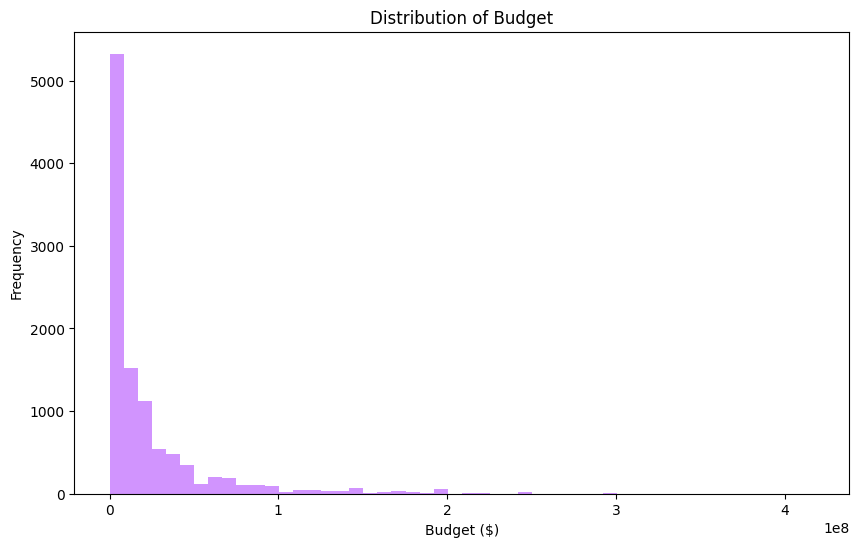

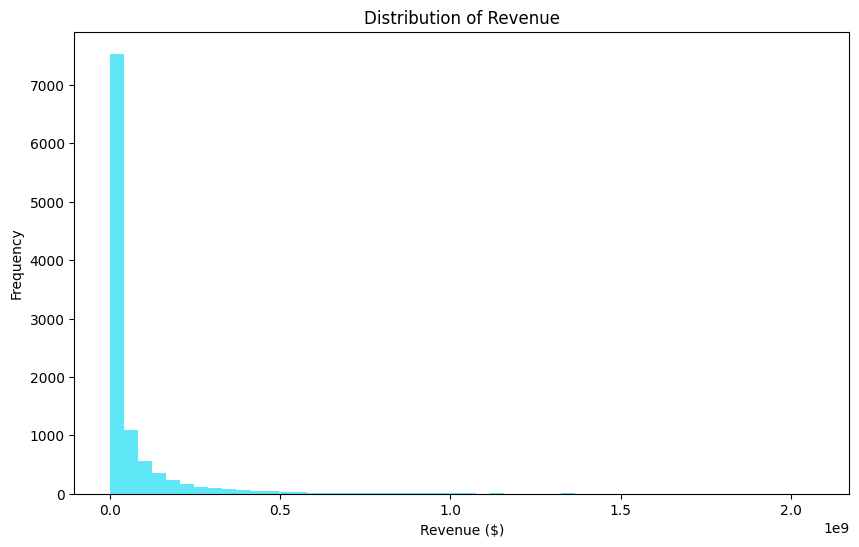

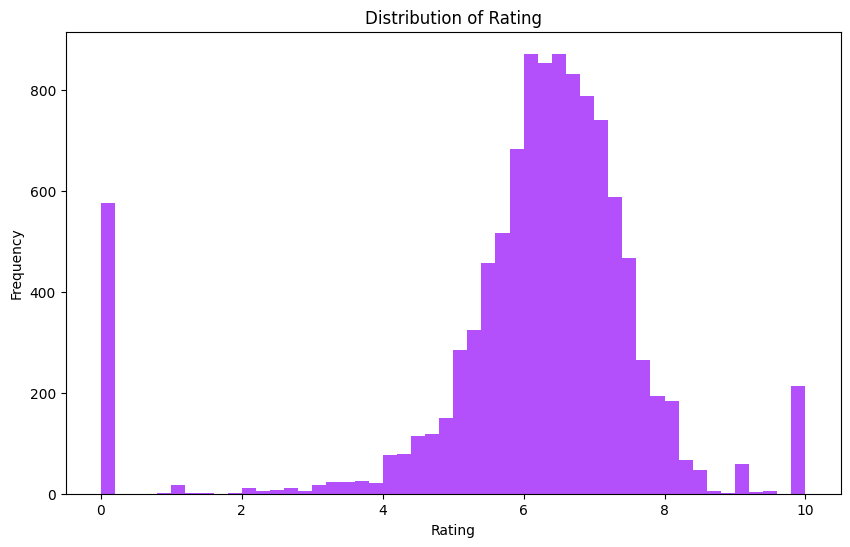

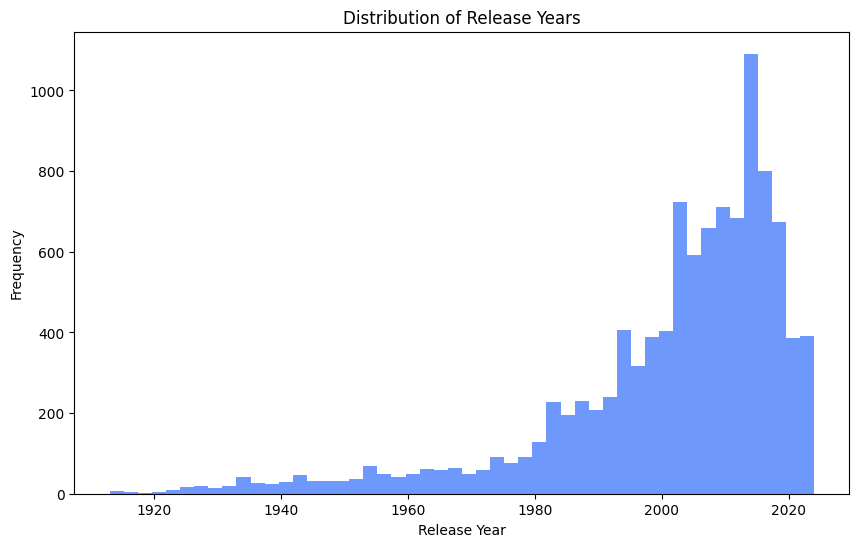

In [ ]:
# Budget Distribution
plt.figure(figsize=(10, 6))
plt.hist(data['budget'], bins=50, color='#be67fe', alpha=0.7)
plt.title('Distribution of Budget')
plt.xlabel('Budget ($)')
plt.ylabel('Frequency')
plt.show()

# Revenue Distribution
plt.figure(figsize=(10, 6))
plt.hist(data['revenue'], bins=50, color='#1bdef5', alpha=0.7)
plt.title('Distribution of Revenue')
plt.xlabel('Revenue ($)')
plt.ylabel('Frequency')
plt.show()

# Rating Distribtion
plt.figure(figsize=(10, 6))
plt.hist(data['vote_average'], bins=50, color='#9405fc', alpha=0.7)
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# Release Year Distribution
plt.figure(figsize=(10, 6))
plt.hist(data['Year_Released'], bins=50, color='#316cfc', alpha=0.7)
plt.title('Distribution of Release Years')
plt.xlabel('Release Year')
plt.ylabel('Frequency')
plt.show()


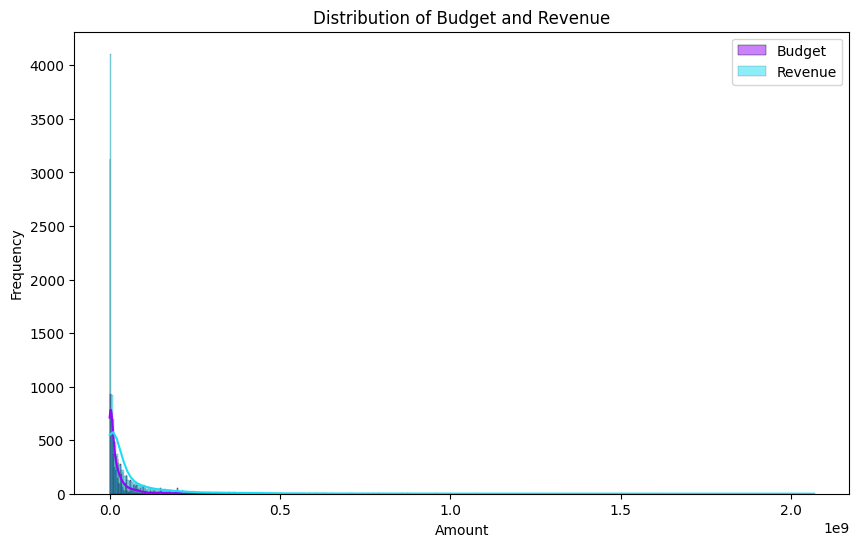

In [ ]:
# Budget vs revenue
plt.figure(figsize=(10, 6))
sns.histplot(data['budget'], color='#9405fc', kde=True, label='Budget')
sns.histplot(data['revenue'], color='#1bdef5', kde=True, label='Revenue')
plt.title('Distribution of Budget and Revenue')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.legend()
plt.show()

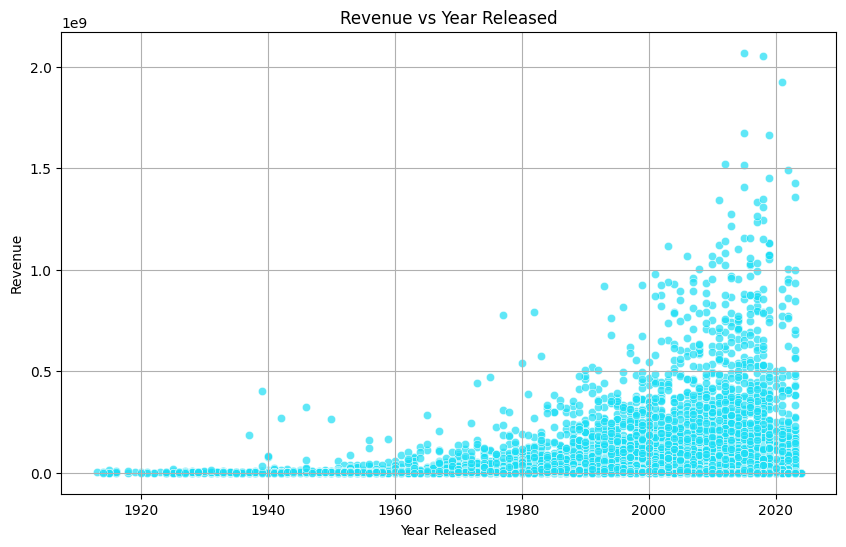

In [ ]:
#Release year and revenue
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Year_Released', y='revenue', data=data, color='#1bdef5', alpha=0.7)
plt.title('Revenue vs Year Released')
plt.xlabel('Year Released')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()

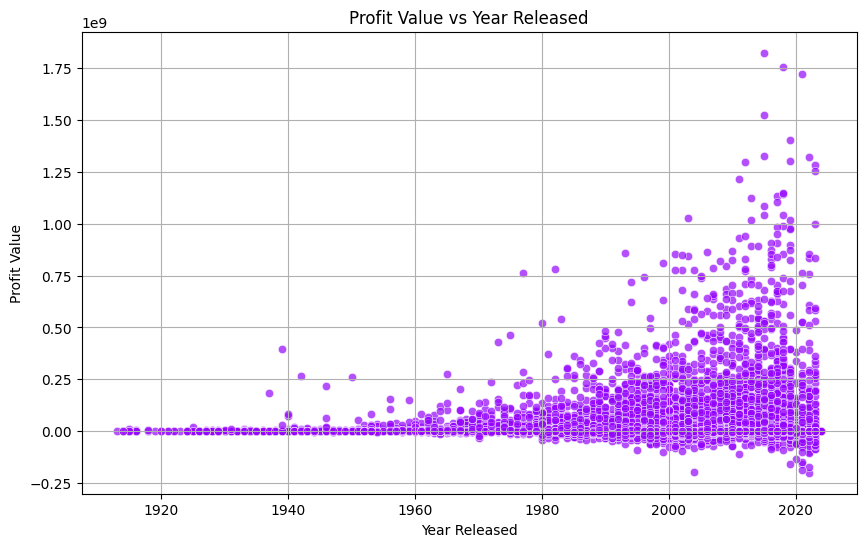

In [ ]:
#Release year and profit
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Year_Released', y='ProfitValue', data=data, color='#9405fc', alpha=0.7)
plt.title('Profit Value vs Year Released')
plt.xlabel('Year Released')
plt.ylabel('Profit Value')
plt.grid(True)
plt.show()

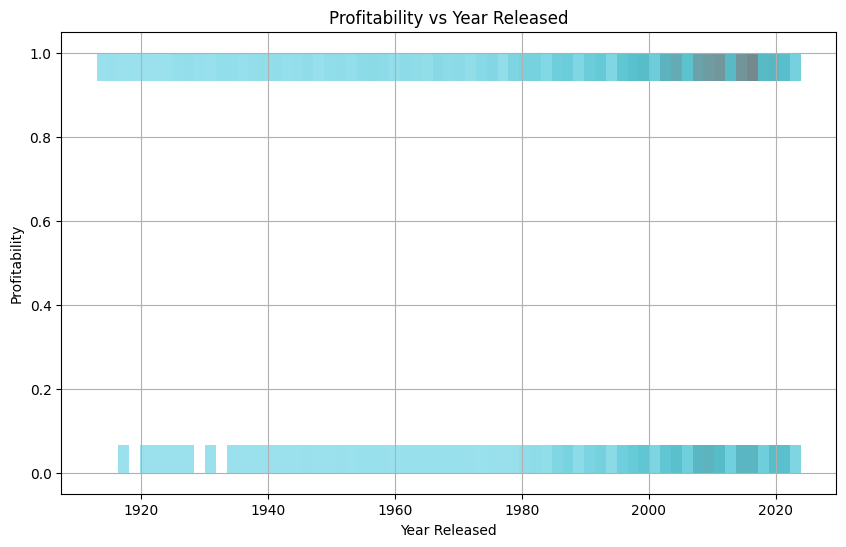

In [ ]:
#Release year and profitability
plt.figure(figsize=(10, 6))
sns.histplot(x='Year_Released', y='Profit_TorF', data=data, color='#1bdef5', alpha=0.7)
plt.title('Profitability vs Year Released')
plt.xlabel('Year Released')
plt.ylabel('Profitability')
plt.grid(True)
plt.show()

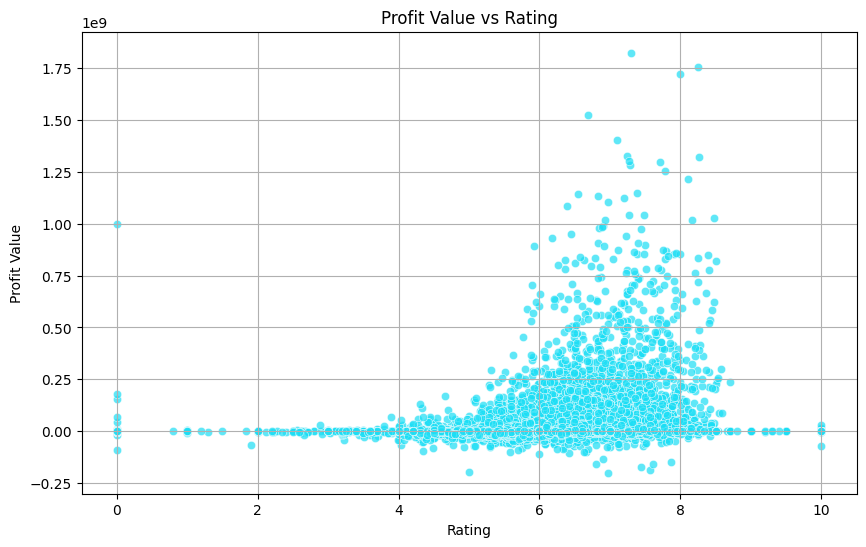

In [ ]:
#Revenue and ratings
plt.figure(figsize=(10, 6))
sns.scatterplot(x='vote_average', y='ProfitValue', data=data, color='#1bdef5', alpha=0.7)
plt.title('Profit Value vs Rating')
plt.xlabel('Rating')
plt.ylabel('Profit Value')
plt.grid(True)
plt.show()

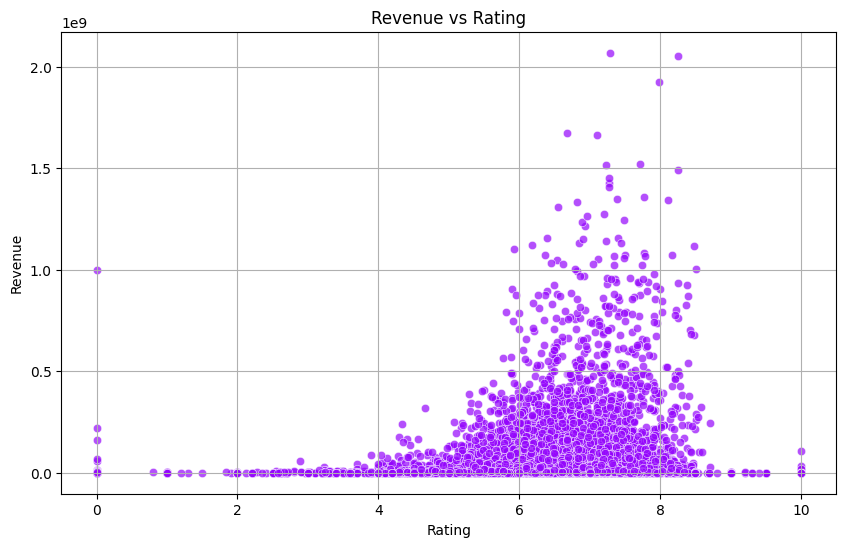

In [ ]:
#Revenue and ratings
plt.figure(figsize=(10, 6))
sns.scatterplot(x='vote_average', y='revenue', data=data, color='#9405fc', alpha=0.7)
plt.title('Revenue vs Rating')
plt.xlabel('Rating')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()

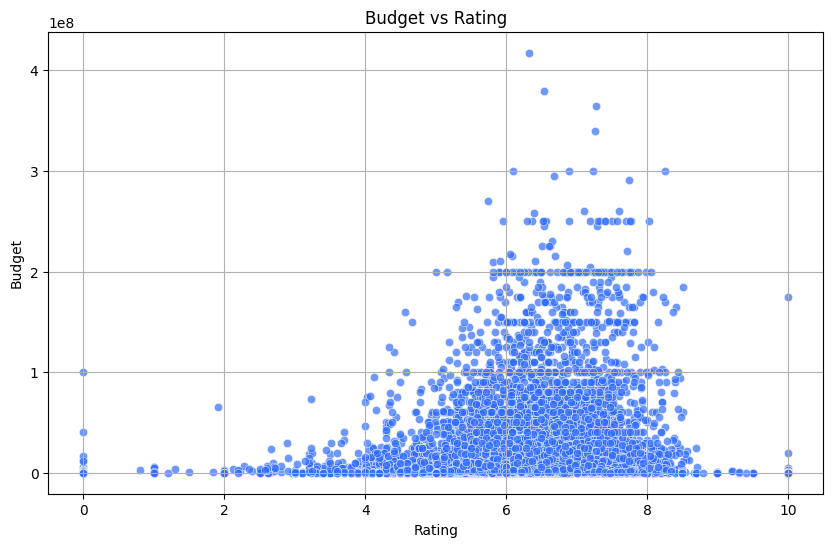

In [ ]:
#Budget and ratings
plt.figure(figsize=(10, 6))
sns.scatterplot(x='vote_average', y='budget', data=data, color='#316cfc', alpha=0.7)
plt.title('Budget vs Rating')
plt.xlabel('Rating')
plt.ylabel('Budget')
plt.grid(True)
plt.show()

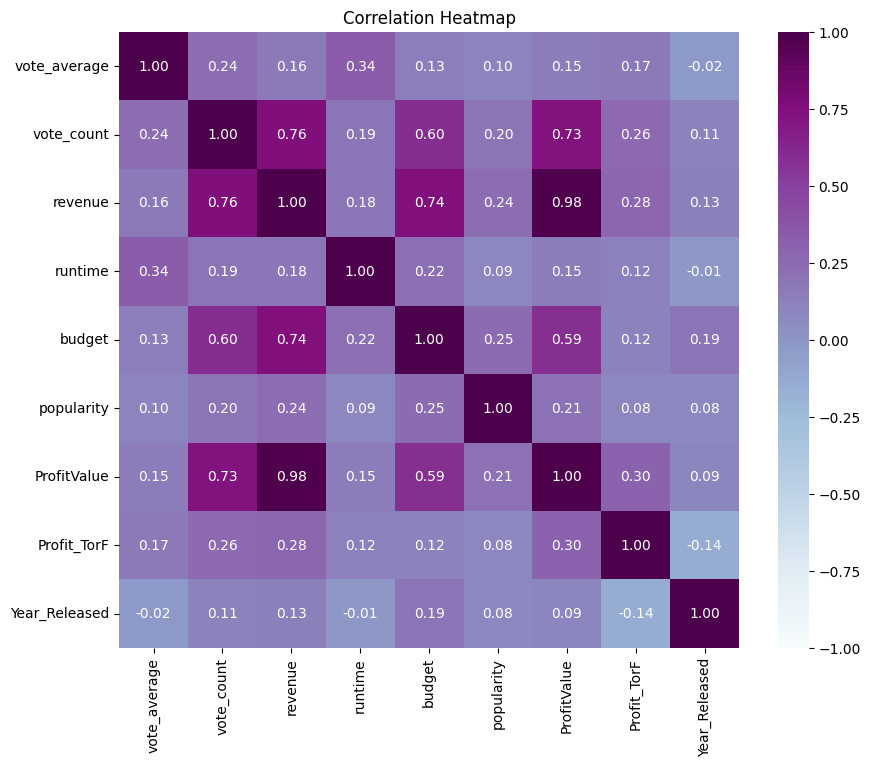

In [ ]:
numerical_columns = ['vote_average', 'vote_count', 'revenue', 'runtime', 'budget', 'popularity', 'ProfitValue', 'Profit_TorF', 'Year_Released']

# Correlation matrix
correlation_matrix = data[numerical_columns].corr()

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='BuPu', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

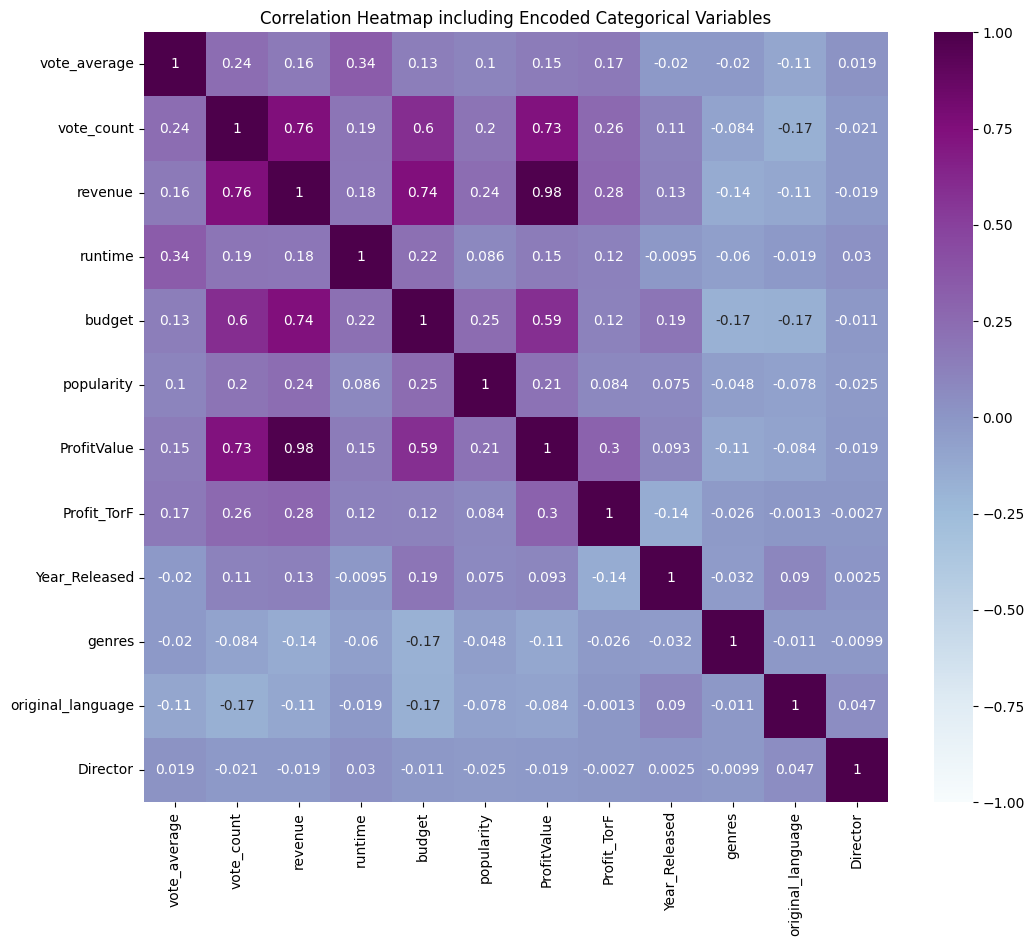

In [ ]:
numerical_columns = ['vote_average', 'vote_count', 'revenue', 'runtime', 'budget', 'popularity', 'ProfitValue', 'Profit_TorF', 'Year_Released']
categorical_columns = ['genres', 'original_language', 'Director']

#Copy of the DF with selected columns
df_encoded = data[numerical_columns + categorical_columns].copy()

# Initialize OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# Fit and transform categorical columns
df_encoded[categorical_columns] = ordinal_encoder.fit_transform(df_encoded[categorical_columns])

# Correlation matrix
corr_matrix = df_encoded.corr()

# Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='BuPu', vmin=-1, vmax=1)
plt.title('Correlation Heatmap including Encoded Categorical Variables')
plt.show()

In [ ]:
# Function to calculate IQR and detect outliers
def detect_outliers(df, column):
    # Calculate Q1 and Q3
    quantiles = df.approxQuantile(column, [0.25, 0.75], 0.01)
    q1, q3 = quantiles[0], quantiles[1]
    iqr = q3 - q1

    # Calculate lower and upper bounds
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Identify outliers
    outliers = df.filter((col(column) < lower_bound) | (col(column) > upper_bound))

    return outliers

#  count outliers
outliers_dict = {}
for feature in numerical_columns:
    outliers = detect_outliers(movie_classified, feature)
    outlier_count = outliers.count()
    outliers_dict[feature] = outliers
    print(f'Number of outliers in {feature}: {outlier_count}')

# Show a few outliers for each feature to inspect
for feature, outliers in outliers_dict.items():
    print(f"\nOutliers for {feature}:")
    outliers.show(10)

# Union all outliers into a single DataFrame for inspection
all_outliers = None
for feature, outliers in outliers_dict.items():
    if all_outliers is None:
        all_outliers = outliers
    else:
        all_outliers = all_outliers.union(outliers).distinct()

print(f'Total number of unique outliers: {all_outliers.count()}')

# Show a few combined outliers to inspect
if all_outliers:
    print("\nCombined outliers from all features:")
    all_outliers.show(10)

Number of outliers in vote_average: 1011
Number of outliers in vote_count: 1272
Number of outliers in revenue: 1395
Number of outliers in runtime: 966
Number of outliers in budget: 1023
Number of outliers in popularity: 633
Number of outliers in ProfitValue: 1660
Number of outliers in Profit_TorF: 0
Number of outliers in Year_Released: 645

Outliers for vote_average:
+-------+--------------------+------------+----------+--------+-------+-------+-----+-------+----------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+----------------+--------------------+-------------+-----------+-----------+-------------+-----+--------------------+--------------------+--------------------+
|     id|               title|vote_average|vote_count|  status|revenue|runtime|adult| budget|   imdb_id|original_language|      original_title|popularity|              genres|production_companies|production_countries|spoken_languages|            keyword

#Machine Learning

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier

In [ ]:
ml_df = movie_classified.select('vote_average', 'revenue', 'runtime', 'budget', 'popularity', 'ProfitValue','Profit_TorF',
                                'Year_Released', 'Covid', 'genres', 'Director')

ml_df.show(5)
ml_df.count()

In [ ]:
ml_df = ml_df.dropna()
ml_df.count()

In [ ]:
cols = ['genres', 'Director']

stages = [StringIndexer(inputCol = column, outputCol = column +"_index").fit(ml_df) for column in cols]


Features = ['vote_average', 'runtime', 'budget', 'popularity', 'Year_Released']
stages.append(VectorAssembler(inputCols=Features, outputCol='Features'))

pipeline = Pipeline(stages=stages)
transformed = pipeline.fit(ml_df).transform(ml_df)

transformed.show(5)

In [ ]:
transformed.select('Features').take(1)

In [ ]:
train, test = transformed.randomSplit([0.8, 0.2], seed=1)

print(train.count(), test.count())

In [ ]:
#filtering lines to just those labeled as Pre Covid
pre_df = transformed.filter(col('Covid') == 'Pre')
pre_df.show(5)
pre_df.count()

In [ ]:
pre_train, pre_test = pre_df.randomSplit([0.8, 0.2], seed=1)

print(pre_train.count(), pre_test.count())

In [ ]:
#filtering lines to just those labeled as Post Covid
post_df = transformed.filter(col('Covid') == 'Post')
post_df.show(5)
post_df.count()

In [ ]:
post_train, post_test = post_df.randomSplit([0.8, 0.2], seed=1)

print(post_train.count(), post_test.count())

####Random Forest - Pre Covid

In [ ]:
rf = RandomForestClassifier(labelCol='Profit_TorF', featuresCol='Features')
model = rf.fit(pre_train)

In [ ]:
predict = model.transform(pre_test)

In [ ]:
# AUC-ROC
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Profit_TorF")
auc = evaluator.evaluate(predict)

# Accuracy, Precision, and Recall
multi_evaluator = MulticlassClassificationEvaluator(labelCol="Profit_TorF", predictionCol="prediction")
accuracy = multi_evaluator.evaluate(predict, {multi_evaluator.metricName: "accuracy"})
precision = multi_evaluator.evaluate(predict, {multi_evaluator.metricName: "weightedPrecision"})
recall = multi_evaluator.evaluate(predict, {multi_evaluator.metricName: "weightedRecall"})

print(f"AUC-ROC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

####Random Forest - Post Covid

In [ ]:
rf = RandomForestClassifier(labelCol='Profit_TorF', featuresCol='Features')
model = rf.fit(post_train)

In [ ]:
predict = model.transform(post_test)

In [ ]:
# AUC-ROC
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Profit_TorF")
auc = evaluator.evaluate(predict)

# Accuracy, Precision, and Recall
multi_evaluator = MulticlassClassificationEvaluator(labelCol="Profit_TorF", predictionCol="prediction")
accuracy = multi_evaluator.evaluate(predict, {multi_evaluator.metricName: "accuracy"})
precision = multi_evaluator.evaluate(predict, {multi_evaluator.metricName: "weightedPrecision"})
recall = multi_evaluator.evaluate(predict, {multi_evaluator.metricName: "weightedRecall"})

print(f"AUC-ROC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

#### Logistic Regression - Pre Covid

In [ ]:
lr = LogisticRegression(labelCol='Profit_TorF', featuresCol='Features')
model = lr.fit(pre_train)

In [ ]:
predict = model.transform(pre_test)

In [ ]:
# AUC-ROC
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Profit_TorF")
auc = evaluator.evaluate(predict)

# Accuracy, Precision, and Recall
multi_evaluator = MulticlassClassificationEvaluator(labelCol="Profit_TorF", predictionCol="prediction")
accuracy = multi_evaluator.evaluate(predict, {multi_evaluator.metricName: "accuracy"})
precision = multi_evaluator.evaluate(predict, {multi_evaluator.metricName: "weightedPrecision"})
recall = multi_evaluator.evaluate(predict, {multi_evaluator.metricName: "weightedRecall"})

print(f"AUC-ROC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

####Logistic Regression - Post Covid

In [ ]:
lr = LogisticRegression(labelCol='Profit_TorF', featuresCol='Features')
model = lr.fit(post_train)

In [ ]:
predict = model.transform(post_test)

In [ ]:
# AUC-ROC
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Profit_TorF")
auc = evaluator.evaluate(predict)

# Accuracy, Precision, and Recall
multi_evaluator = MulticlassClassificationEvaluator(labelCol="Profit_TorF", predictionCol="prediction")
accuracy = multi_evaluator.evaluate(predict, {multi_evaluator.metricName: "accuracy"})
precision = multi_evaluator.evaluate(predict, {multi_evaluator.metricName: "weightedPrecision"})
recall = multi_evaluator.evaluate(predict, {multi_evaluator.metricName: "weightedRecall"})

print(f"AUC-ROC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

###Neural Network Pre-Covid

In [ ]:
mlp = MultilayerPerceptronClassifier(labelCol='Profit_TorF', featuresCol='Features', layers=layers)
model = mlp.fit(pre_train)

In [ ]:
predict = model.transform(pre_test)

In [ ]:
# AUC-ROC
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Profit_TorF")
auc = evaluator.evaluate(predict)

# Accuracy, Precision, and Recall
multi_evaluator = MulticlassClassificationEvaluator(labelCol="Profit_TorF", predictionCol="prediction")
accuracy = multi_evaluator.evaluate(predict, {multi_evaluator.metricName: "accuracy"})
precision = multi_evaluator.evaluate(predict, {multi_evaluator.metricName: "weightedPrecision"})
recall = multi_evaluator.evaluate(predict, {multi_evaluator.metricName: "weightedRecall"})

print(f"AUC-ROC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

###Neural Network Post-Covid

In [ ]:
mlp = MultilayerPerceptronClassifier(labelCol='Profit_TorF', featuresCol='Features', layers=layers)
model = mlp.fit(post_train)

In [ ]:
predict = model.transform(post_test)

In [ ]:
# AUC-ROC
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="Profit_TorF")
auc = evaluator.evaluate(predict)

# Accuracy, Precision, and Recall
multi_evaluator = MulticlassClassificationEvaluator(labelCol="Profit_TorF", predictionCol="prediction")
accuracy = multi_evaluator.evaluate(predict, {multi_evaluator.metricName: "accuracy"})
precision = multi_evaluator.evaluate(predict, {multi_evaluator.metricName: "weightedPrecision"})
recall = multi_evaluator.evaluate(predict, {multi_evaluator.metricName: "weightedRecall"})

print(f"AUC-ROC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

#Initial Model Comparison

###Initial Model Comparison Pre-Covid

In [ ]:
import matplotlib.pyplot as plt

# Define the metrics for each model
models = ['Random Forest', 'Logistic Regression', 'Neural Network']
auc_roc = [0.7676, 0.7313, 0.5059 ]
accuracy = [0.7156, 0.6742, 0.6588 ]
precision = [0.7048, 0.6449,  0.5770 ]
recall = [0.7156, 0.6742, 0.6588 ]

# Plotting
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# AUC-ROC
ax[0, 0].bar(models, auc_roc, color=['#0072BD', '#D95319', '#EDB120'])
ax[0, 0].set_title('AUC-ROC')
ax[0, 0].set_ylabel('Score')

# Accuracy
ax[0, 1].bar(models, accuracy, color=['#0072BD', '#D95319', '#EDB120'])
ax[0, 1].set_title('Accuracy')
ax[0, 1].set_ylabel('Score')

# Precision
ax[1, 0].bar(models, precision, color=['#0072BD', '#D95319', '#EDB120'])
ax[1, 0].set_title('Precision')
ax[1, 0].set_ylabel('Score')

# Recall
ax[1, 1].bar(models, recall, color=['#0072BD', '#D95319', '#EDB120'])
ax[1, 1].set_title('Recall')
ax[1, 1].set_ylabel('Score')

plt.tight_layout()
plt.show()

###Initial Model Comparison Post-Covid

In [ ]:
import matplotlib.pyplot as plt

# Define the metrics for each model
models = ['Random Forest', 'Logistic Regression', 'Neural Network']
auc_roc = [0.6549, 0.5586, 0.5065]
accuracy = [0.5870, 0.4928, 0.4783]
precision = [0.5883, 0.2428, 0.4602 ]
recall = [0.5870, 0.4928, 0.4783]

# Plotting
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# AUC-ROC
ax[0, 0].bar(models, auc_roc, color=['#0072BD', '#D95319', '#EDB120'])
ax[0, 0].set_title('AUC-ROC')
ax[0, 0].set_ylabel('Score')

# Accuracy
ax[0, 1].bar(models, accuracy, color=['#0072BD', '#D95319', '#EDB120'])
ax[0, 1].set_title('Accuracy')
ax[0, 1].set_ylabel('Score')

# Precision
ax[1, 0].bar(models, precision, color=['#0072BD', '#D95319', '#EDB120'])
ax[1, 0].set_title('Precision')
ax[1, 0].set_ylabel('Score')

# Recall
ax[1, 1].bar(models, recall, color=['#0072BD', '#D95319', '#EDB120'])
ax[1, 1].set_title('Recall')
ax[1, 1].set_ylabel('Score')

plt.tight_layout()
plt.show()

In [ ]:
#Pre COVID data

X_train = np.array(pre_train.select('Features').collect()).squeeze() # Squeeze to remove extra dimension
y_train = np.array(pre_train.select('Profit_TorF').collect()).ravel() # Ravel to flatten the array
X_test = np.array(pre_test.select('Features').collect()).squeeze()   # Squeeze to remove extra dimension
y_test = np.array(pre_test.select('Profit_TorF').collect()).ravel()   # Ravel to flatten the array

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models and parameter grids
models = {
    'random_forest': (RandomForestClassifier(), {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}),
    'logistic_regression': (LogisticRegression(max_iter=1000), {'C': [0.1, 1, 10]}),
    'neural_network': (MLPClassifier(max_iter=1000), {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'alpha': [0.0001, 0.001],
        'learning_rate_init': [0.001, 0.01],
        'early_stopping': [True]
    })
}

# Outer K-Fold
outer_kf = KFold(n_splits=5, shuffle=True, random_state=42)
outer_results = {}

for model_name, (model, param_grid) in models.items():
    outer_fold_results = {'mse': [], 'roc_auc': [], 'accuracy': [], 'precision': [], 'recall': []}

    for train_index, val_index in outer_kf.split(X_train_scaled):
        X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Inner K-Fold for hyperparameter tuning
        inner_kf = KFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(model, param_grid, cv=inner_kf, scoring='neg_mean_squared_error')
        grid_search.fit(X_train_fold, y_train_fold)

        # Best model from inner CV
        best_model = grid_search.best_estimator_

        # Evaluate on outer fold
        y_pred = best_model.predict(X_val_fold)
        y_pred_proba = best_model.predict_proba(X_val_fold)[:, 1] if hasattr(best_model, "predict_proba") else None

        outer_fold_results['mse'].append(mean_squared_error(y_val_fold, y_pred))
        outer_fold_results['roc_auc'].append(roc_auc_score(y_val_fold, y_pred_proba) if y_pred_proba is not None else np.nan)
        outer_fold_results['accuracy'].append(accuracy_score(y_val_fold, y_pred))
        outer_fold_results['precision'].append(precision_score(y_val_fold, y_pred))
        outer_fold_results['recall'].append(recall_score(y_val_fold, y_pred))

    outer_results[model_name] = {metric: np.mean(scores) for metric, scores in outer_fold_results.items()}

print("Model Performance (Cross-Validation):")
for model_name, metrics in outer_results.items():
    print(f"{model_name}:")
    for metric, score in metrics.items():
        print(f"  {metric}: {score:.4f}")

# Final evaluation on the test set using the best model of each type
test_results = {}
for model_name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, cv=outer_kf, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_scaled, y_train)
    best_model = grid_search.best_estimator_
    y_test_pred = best_model.predict(X_test_scaled)
    y_test_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1] if hasattr(best_model, "predict_proba") else None

    test_results[model_name] = {
        'mse': mean_squared_error(y_test, y_test_pred),
        'roc_auc': roc_auc_score(y_test, y_test_pred_proba) if y_test_pred_proba is not None else np.nan,
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred)
    }

print("\nTest Performance:")
for model_name, metrics in test_results.items():
    print(f"{model_name}:")
    for metric, score in metrics.items():
        print(f"  {metric}: {score:.4f}")

In [ ]:
#Post COVID data

X_train = np.array(post_train.select('Features').collect()).squeeze() # Squeeze to remove extra dimension
y_train = np.array(post_train.select('Profit_TorF').collect()).ravel() # Ravel to flatten the array
X_test = np.array(post_test.select('Features').collect()).squeeze()   # Squeeze to remove extra dimension
y_test = np.array(post_test.select('Profit_TorF').collect()).ravel()   # Ravel to flatten the array

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models and parameter grids
models = {
    'random_forest': (RandomForestClassifier(), {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}),
    'logistic_regression': (LogisticRegression(max_iter=1000), {'C': [0.1, 1, 10]}),
    'neural_network': (MLPClassifier(max_iter=1000), {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'alpha': [0.0001, 0.001],
        'learning_rate_init': [0.001, 0.01],
        'early_stopping': [True]
    })
}

# Outer K-Fold
outer_kf = KFold(n_splits=5, shuffle=True, random_state=42)
outer_results = {}

for model_name, (model, param_grid) in models.items():
    outer_fold_results = {'mse': [], 'roc_auc': [], 'accuracy': [], 'precision': [], 'recall': []}

    for train_index, val_index in outer_kf.split(X_train_scaled):
        X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Inner K-Fold for hyperparameter tuning
        inner_kf = KFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(model, param_grid, cv=inner_kf, scoring='neg_mean_squared_error')
        grid_search.fit(X_train_fold, y_train_fold)

        # Best model from inner CV
        best_model = grid_search.best_estimator_

        # Evaluate on outer fold
        y_pred = best_model.predict(X_val_fold)
        y_pred_proba = best_model.predict_proba(X_val_fold)[:, 1] if hasattr(best_model, "predict_proba") else None

        outer_fold_results['mse'].append(mean_squared_error(y_val_fold, y_pred))
        outer_fold_results['roc_auc'].append(roc_auc_score(y_val_fold, y_pred_proba) if y_pred_proba is not None else np.nan)
        outer_fold_results['accuracy'].append(accuracy_score(y_val_fold, y_pred))
        outer_fold_results['precision'].append(precision_score(y_val_fold, y_pred))
        outer_fold_results['recall'].append(recall_score(y_val_fold, y_pred))

    outer_results[model_name] = {metric: np.mean(scores) for metric, scores in outer_fold_results.items()}

print("Model Performance (Cross-Validation):")
for model_name, metrics in outer_results.items():
    print(f"{model_name}:")
    for metric, score in metrics.items():
        print(f"  {metric}: {score:.4f}")

# Final evaluation on the test set using the best model of each type
test_results = {}
for model_name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, cv=outer_kf, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_scaled, y_train)
    best_model = grid_search.best_estimator_
    y_test_pred = best_model.predict(X_test_scaled)
    y_test_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1] if hasattr(best_model, "predict_proba") else None

    test_results[model_name] = {
        'mse': mean_squared_error(y_test, y_test_pred),
        'roc_auc': roc_auc_score(y_test, y_test_pred_proba) if y_test_pred_proba is not None else np.nan,
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred)
    }

print("\nTest Performance:")
for model_name, metrics in test_results.items():
    print(f"{model_name}:")
    for metric, score in metrics.items():
        print(f"  {metric}: {score:.4f}")